In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import scipy.stats as stats

In [3]:
df_vale = yf.download('VALE3.SA', start='2018-01-01', end='2024-12-31', multi_level_index=False)
df_vale = df_vale[['Close', 'Open']]
df_vale.reset_index(inplace=True)
df_vale['Date'] = pd.to_datetime(df_vale['Date'])
df_vale.set_index('Date', inplace=True)
df_vale

[*********************100%***********************]  1 of 1 completed


,Close,Open
Date,,
2018-01-02,23.603910,22.879724
2018-01-03,23.462469,23.666147
2018-01-04,23.558655,23.654837
2018-01-05,23.926399,23.519044
2018-01-08,24.458227,23.988639
...,...,...
2024-12-20,52.568302,51.413377
2024-12-23,52.789661,52.616422
2024-12-26,52.943653,52.789663


# Médias móveis: 

* Médias móveis simples:

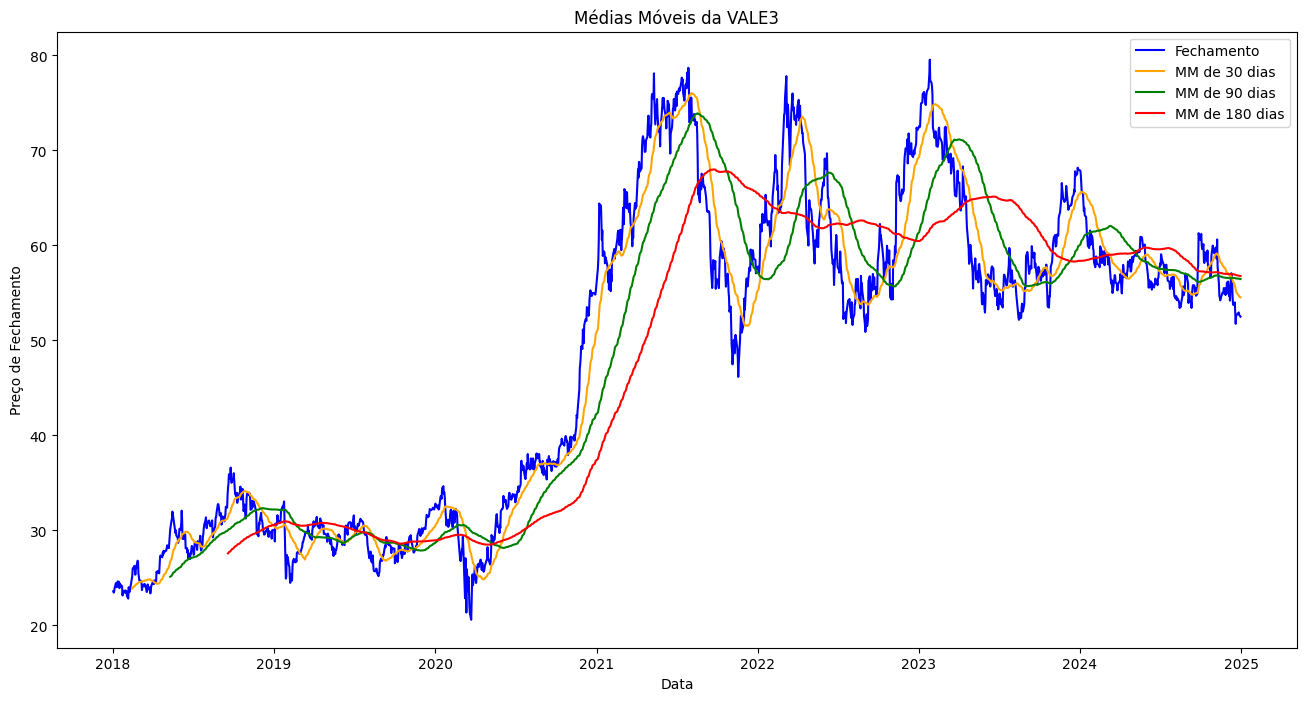

In [14]:
# Calculando as Médias Móveis:
df_vale['mm_7D'] = df_vale['Close'].rolling(window=7).mean()
df_vale['mm_15D'] = df_vale['Close'].rolling(window=15).mean()
df_vale['mm_30D'] = df_vale['Close'].rolling(window=30).mean()
df_vale['mm_90D'] = df_vale['Close'].rolling(window=90).mean()
df_vale['mm_180D'] = df_vale['Close'].rolling(window=180).mean()
# Plotando as Médias Móveis:
plt.figure(figsize=(16,8))
plt.plot(df_vale['Close'], label='Fechamento', color='blue')
plt.plot(df_vale['mm_30D'], label='MM de 30 dias', color='orange')
plt.plot(df_vale['mm_90D'], label='MM de 90 dias', color='green')
plt.plot(df_vale['mm_180D'], label='MM de 180 dias', color='red')
plt.title('Médias Móveis da VALE3')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

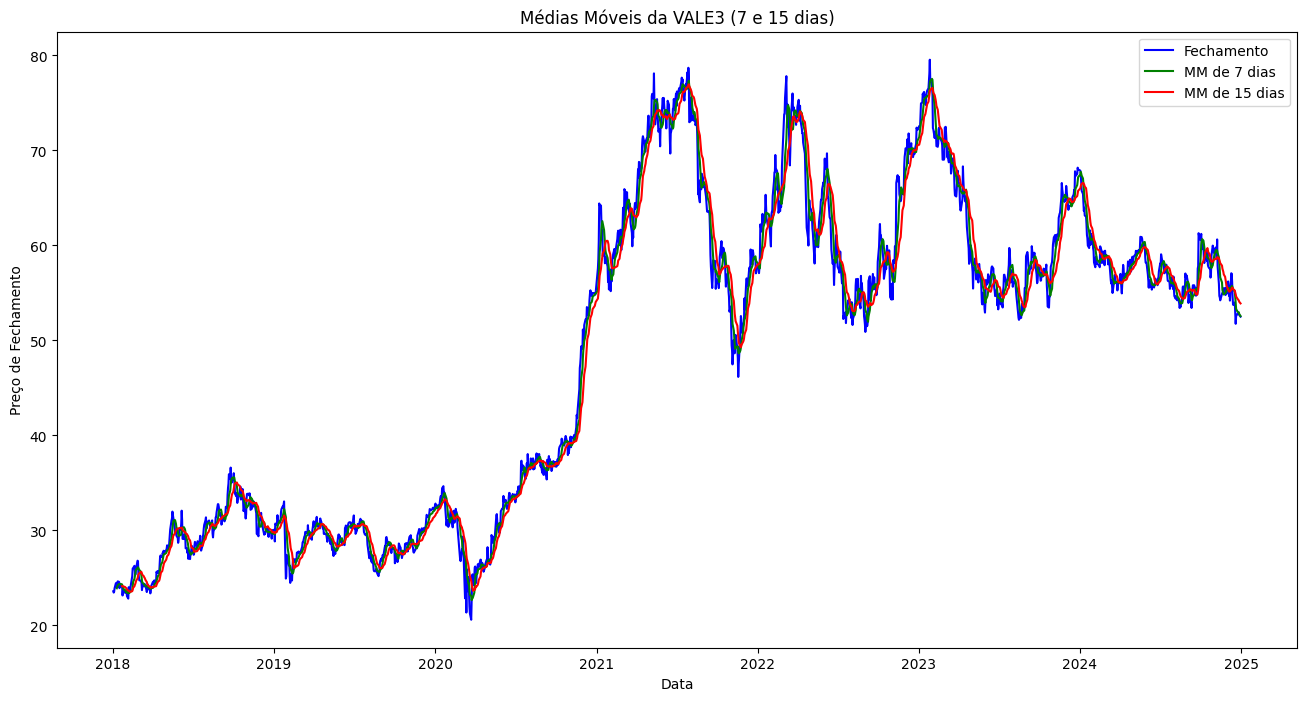

In [16]:
plt.figure(figsize=(16,8))
plt.plot(df_vale['Close'], label='Fechamento', color='blue')
plt.plot(df_vale['mm_7D'], label='MM de 7 dias', color='green')
plt.plot(df_vale['mm_15D'], label='MM de 15 dias', color='red')
plt.title('Médias Móveis da VALE3 (7 e 15 dias)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

* Médias móveis exponenciais:

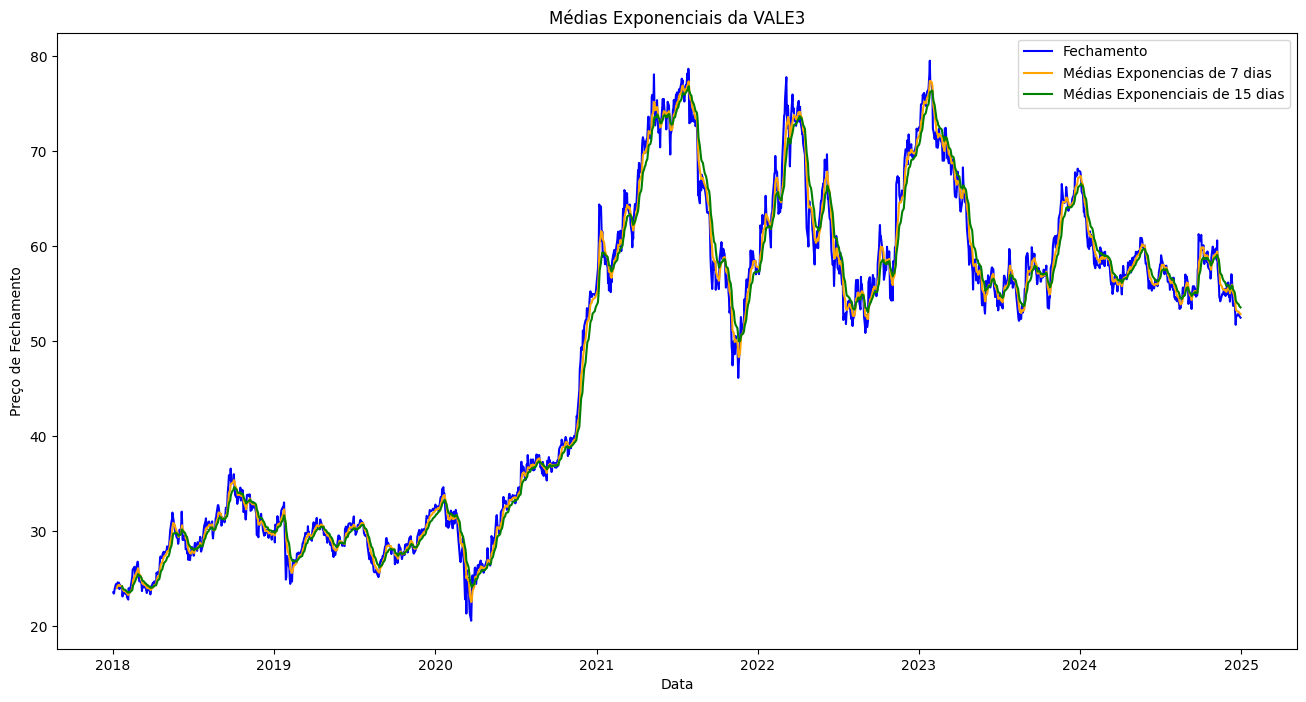

In [7]:
# Calculando Médias Exponenciais:
exp7dias = df_vale['Close'].ewm(span=7, min_periods=7).mean()
exp15dias = df_vale['Close'].ewm(span=15, min_periods=15).mean()
# Plotando Médias Exponenciais:
plt.figure(figsize=(16,8))
plt.plot(df_vale['Close'], label='Fechamento', color='blue')
plt.plot(exp7dias, label='Médias Exponencias de 7 dias', color='orange')
plt.plot(exp15dias, label='Médias Exponenciais de 15 dias', color='green')
plt.title('Médias Exponenciais da VALE3')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

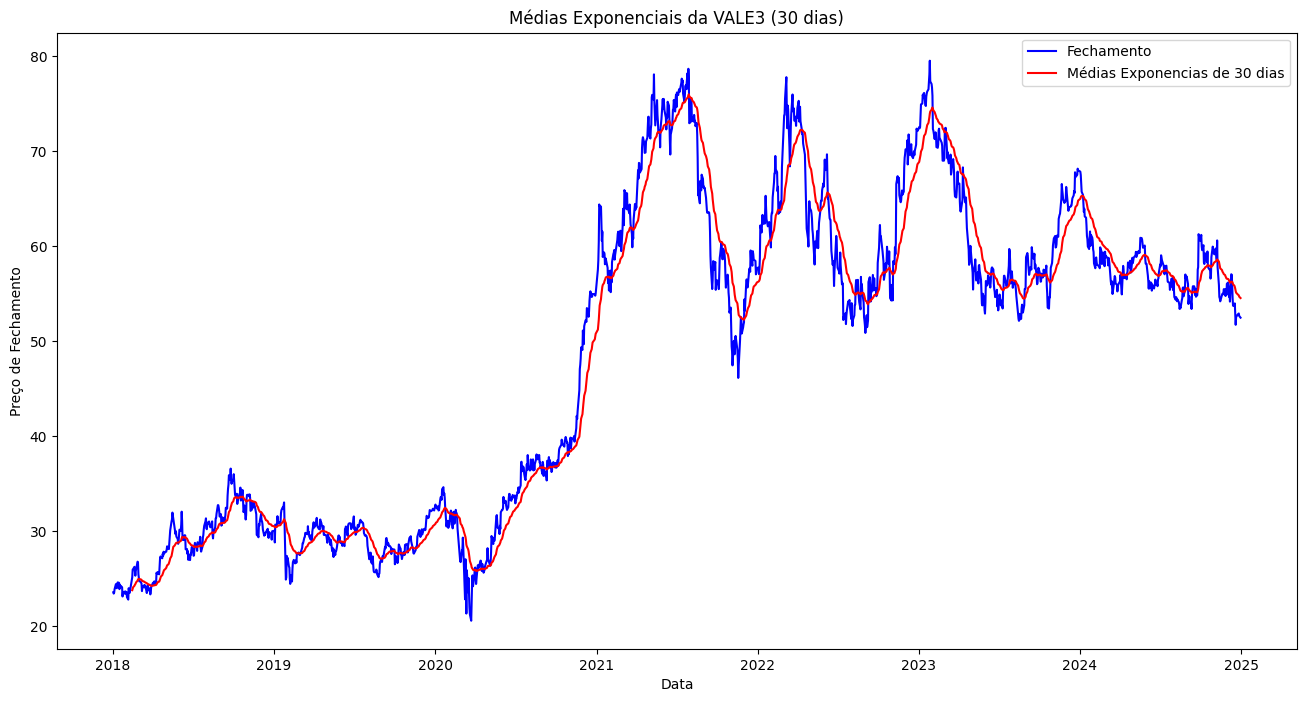

In [17]:
exp30dias = df_vale['Close'].ewm(span=30, min_periods=30).mean()
plt.figure(figsize=(16,8))
plt.plot(df_vale['Close'], label='Fechamento', color='blue')
plt.plot(exp30dias, label='Médias Exponencias de 30 dias', color='red')
plt.title('Médias Exponenciais da VALE3 (30 dias)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

* Podemos observar que as médias, tanto as móveis quanto as exponenciais, de curto prazo(7 dias e 15 dias) reagem mais rapidamente a quedas bruscas e alta nos preços. 
* As Médias de 30 dias conseguem suavizar as tendências e aindam acompanham bem a variação dos preços das ações.
* Médias mais longas suavizam mais lentamente. 
* Isso é útil para traders de curto prazo, já os investidores de longo prazo podem esperar uma alta volatilidade do preço das ações da VALE3.

# Bandas de Bollinger:

* Bandas de Bollinger de 15 dias:

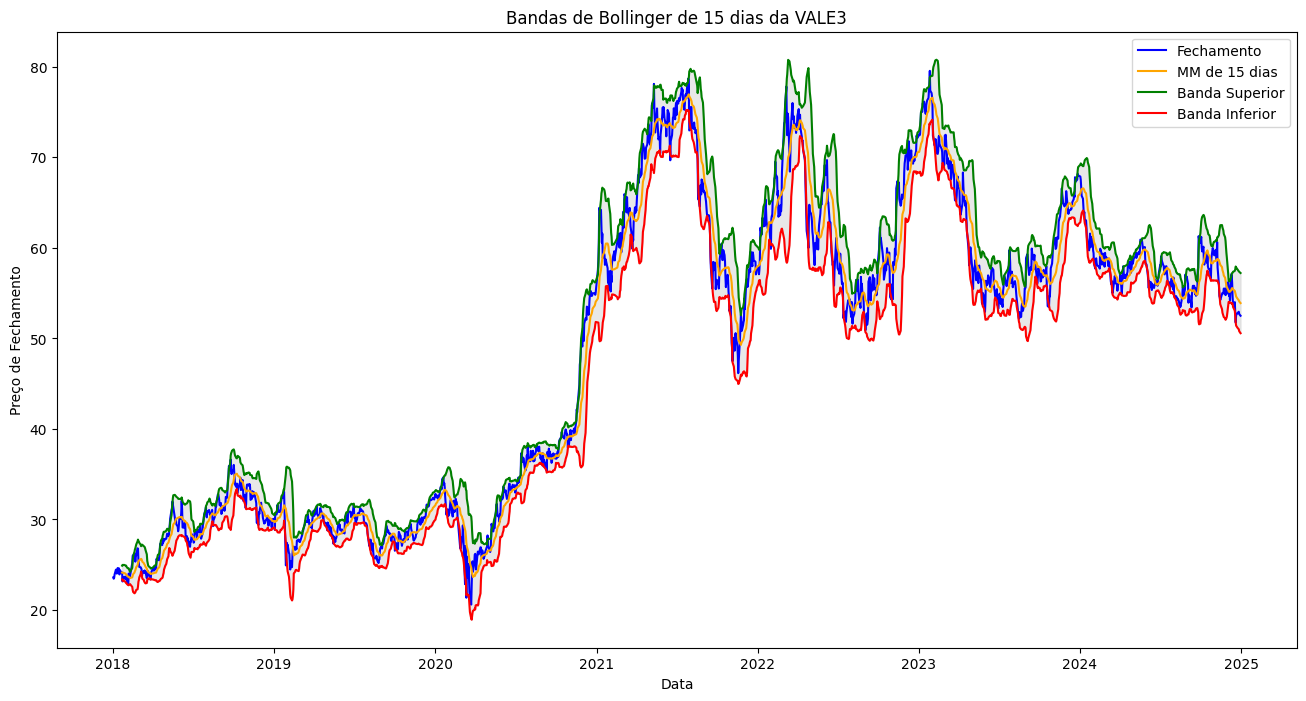

In [19]:
std15dias = df_vale['Close'].rolling(window=15).std()
df_vale['upper_band15'] = df_vale['mm_15D'] + (2 * std15dias)
df_vale['lower_band15'] = df_vale['mm_15D'] - (2 * std15dias)
plt.figure(figsize=(16,8))
plt.plot(df_vale['Close'], label='Fechamento', color='blue')
plt.plot(df_vale['mm_15D'], label='MM de 15 dias', color='orange')
plt.plot(df_vale['upper_band15'], label='Banda Superior', color='green')
plt.plot(df_vale['lower_band15'], label='Banda Inferior', color='red')
plt.fill_between(df_vale.index, df_vale['upper_band15'], df_vale['lower_band15'], color='lightgray', alpha=0.5)
plt.title('Bandas de Bollinger de 15 dias da VALE3')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

* Bandas de Bollinger de 30 dias:

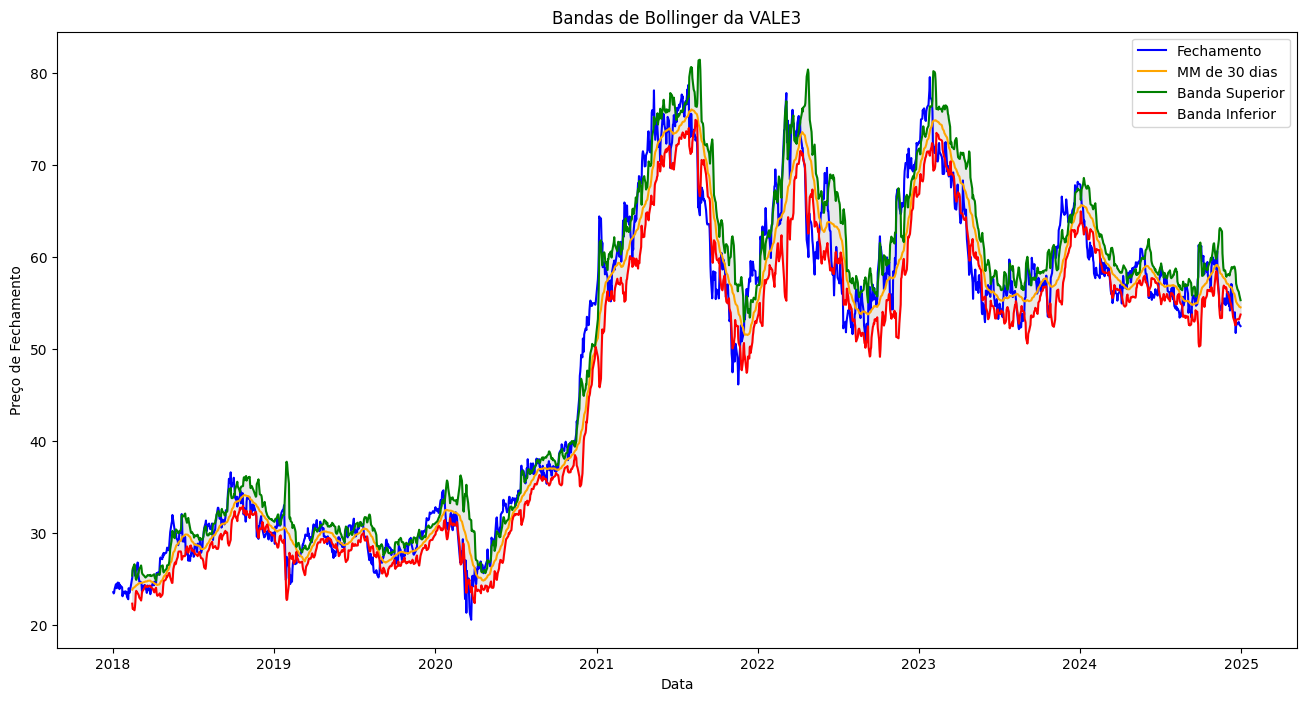

In [20]:
std30dias = df_vale['Close'].rolling(window=30).std()
df_vale['upper_band30'] = df_vale['mm_30D'] + (2 * std7dias)
df_vale['lower_band30'] = df_vale['mm_30D'] - (2 * std7dias)
plt.figure(figsize=(16,8))
plt.plot(df_vale['Close'], label='Fechamento', color='blue')
plt.plot(df_vale['mm_30D'], label='MM de 30 dias', color='orange')
plt.plot(df_vale['upper_band30'], label='Banda Superior', color='green')
plt.plot(df_vale['lower_band30'], label='Banda Inferior', color='red')
plt.fill_between(df_vale.index, df_vale['upper_band30'], df_vale['lower_band30'], color='lightgray', alpha=0.5)
plt.title('Bandas de Bollinger da VALE3')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()


* Bandas de 15 dias vs. 30 dias

1. As bandas de 15 dias são mais sensíveis às variações de curto prazo:
Geram mais sinais, mas também mais falsos positivos.

2. As bandas de 30 dias são mais suaves:
Menos ruído, melhores para identificar tendências consolidadas.